# Linear Regression Model

This is where I work with the merged dataframe to fit a linear regression model in order to predict the opening box office gross

In [31]:
# all of the imports
import pandas as pd
import numpy as np
import pickle 
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
% matplotlib inline
%config InlineBackend.figure_format = 'png'
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

import warnings
warnings.filterwarnings('ignore')

In [32]:
# Import merged dataframe
merged2 = pd.read_pickle('prelim_merged.pkl')


In [33]:
merged2.head(3)

,movie_name,movie,op_gross,est_tick,date_time,theaters,Yviews,Ycomments,Ydislikes,Ylikes,actors,director,imdb,metacritic,rated,rotten_tomatoes,runtime,year,tick
0,The Hunger Games: Catching Fire,The Hunger Games: Catching Fire,158074286,19443331,2013-11-22,4163,12389287,9493,1385,52030,"Jennifer Lawrence, Liam Hemsworth, Jack Quaid,...",Francis Lawrence,7.5,76,PG-13,89,146,2013,8.13
1,Iron Man 3,Iron Man 3,174144585,21419998,2013-05-03,4253,1274074,1643,259,7201,"Robert Downey Jr., Gwyneth Paltrow, Don Cheadl...",Shane Black,7.2,62,PG-13,80,130,2013,8.13
2,Frozen,Frozen,243390,29937,2013-11-22,1,34267342,7458,8664,54157,"Kristen Bell, Idina Menzel, Jonathan Groff, Jo...","Chris Buck, Jennifer Lee",7.5,74,PG,90,102,2013,8.13


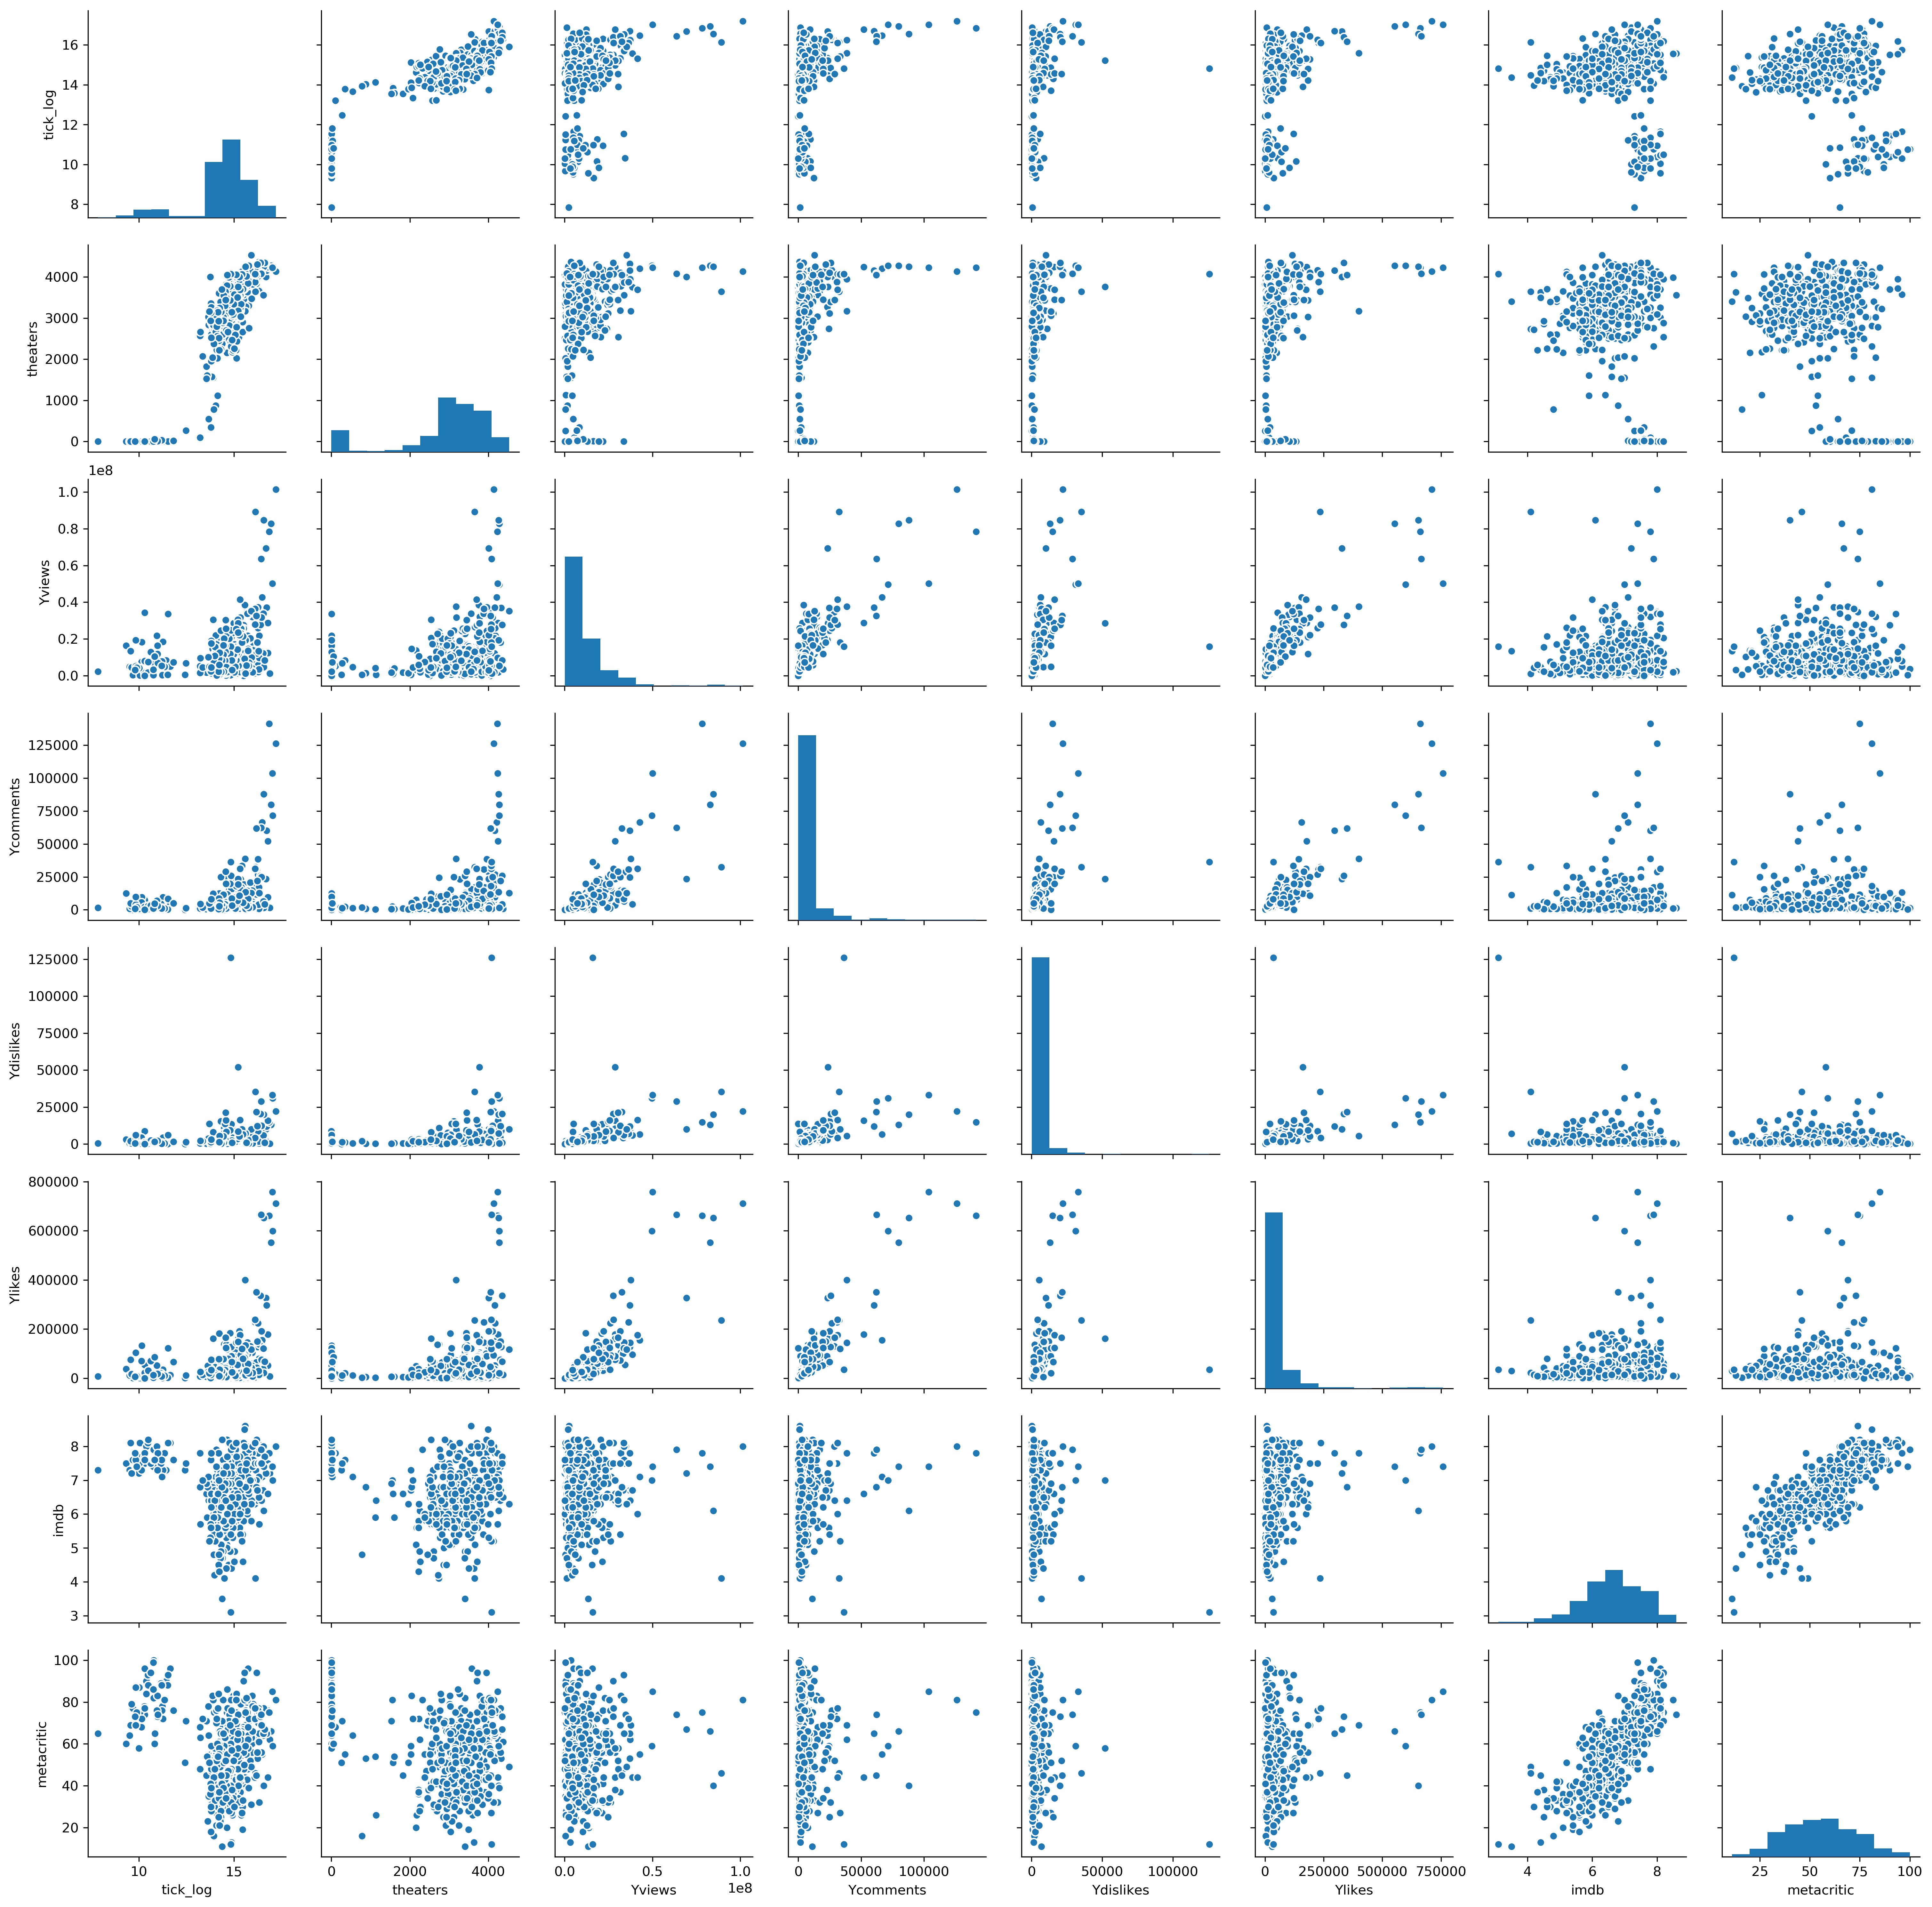

In [60]:
sns.pairplot(merged3.iloc[:,[23,5,6,7,8,9,12,13]])
#len(merged3.columns)

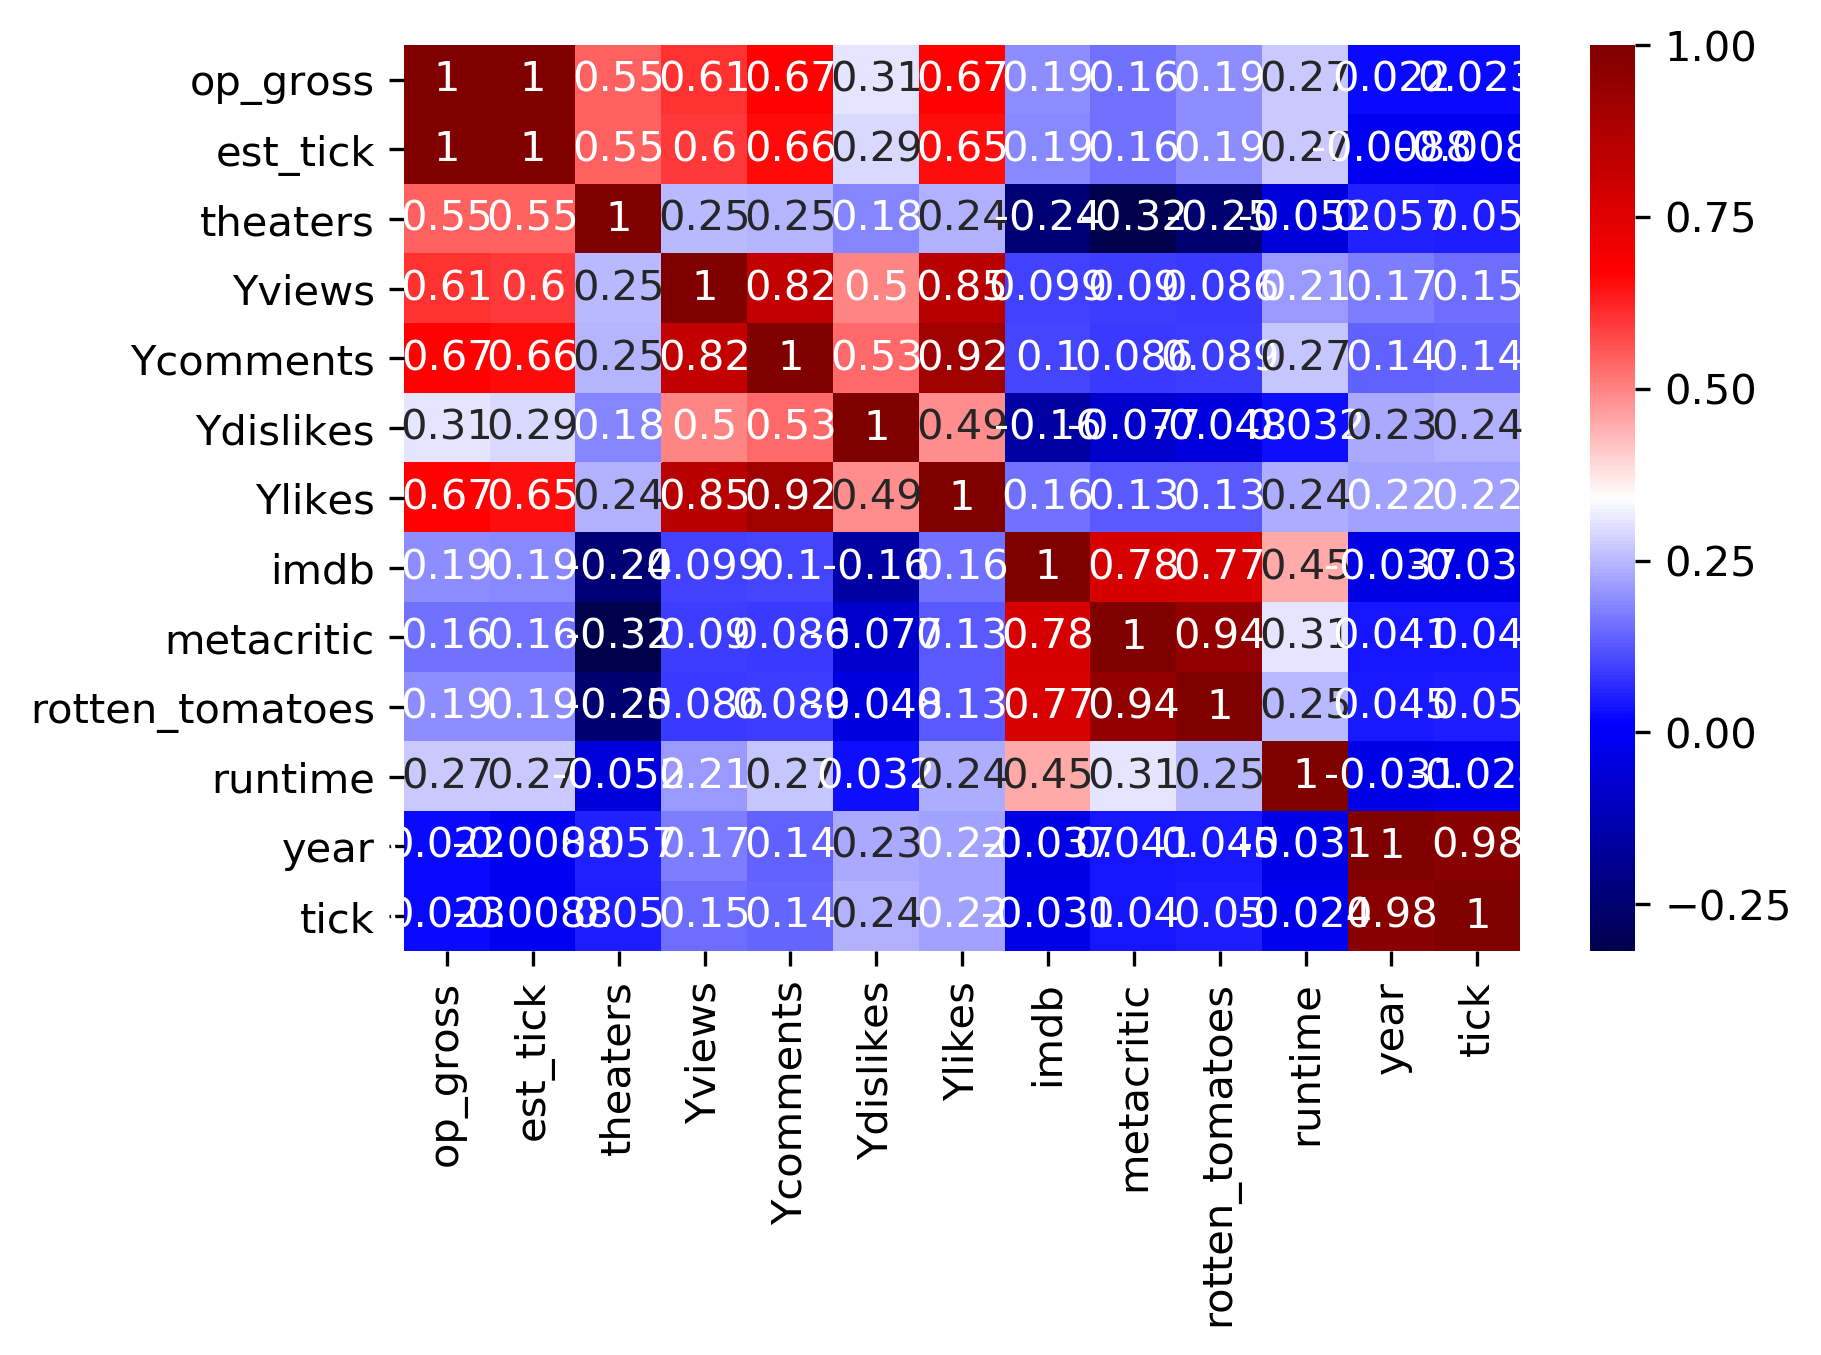

In [35]:
sns.heatmap(merged2.corr(), cmap = "seismic", annot=True)

In [36]:
X=patsy.dmatrix('rated',data=merged2,return_type='dataframe')
X.head()

,Intercept,rated[T.PG],rated[T.PG-13],rated[T.R]
0,1.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0
2,1.0,1.0,0.0,0.0
3,1.0,1.0,0.0,0.0
4,1.0,0.0,1.0,0.0


In [37]:
merged3 = merged2.join(X)
merged3.head()

,movie_name,movie,op_gross,est_tick,date_time,theaters,Yviews,Ycomments,Ydislikes,Ylikes,...,metacritic,rated,rotten_tomatoes,runtime,year,tick,Intercept,rated[T.PG],rated[T.PG-13],rated[T.R]
0,The Hunger Games: Catching Fire,The Hunger Games: Catching Fire,158074286,19443331,2013-11-22,4163,12389287,9493,1385,52030,...,76,PG-13,89,146,2013,8.13,1.0,0.0,1.0,0.0
1,Iron Man 3,Iron Man 3,174144585,21419998,2013-05-03,4253,1274074,1643,259,7201,...,62,PG-13,80,130,2013,8.13,1.0,0.0,1.0,0.0
2,Frozen,Frozen,243390,29937,2013-11-22,1,34267342,7458,8664,54157,...,74,PG,90,102,2013,8.13,1.0,1.0,0.0,0.0
3,Despicable Me 2,Despicable Me 2,83517315,10272732,2013-07-03,3997,7725854,2146,1733,17764,...,62,PG,74,98,2013,8.13,1.0,1.0,0.0,0.0
4,Man of Steel,Man of Steel,116619362,14344324,2013-06-14,4207,42683390,66568,6511,155344,...,55,PG-13,55,143,2013,8.13,1.0,0.0,1.0,0.0


In [52]:
merged3["tick_log"] = np.log(merged3.est_tick)

In [55]:
y = merged3.tick_log
X = merged3.drop(['tick_log','op_gross','movie_name','movie','date_time','actors','director','year','rated','est_tick'],1)

model= LinearRegression()
model.fit(X,y)
model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [56]:
# Create your model
model = sm.OLS(y,X)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               tick_log   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     193.0
Date:                Thu, 19 Apr 2018   Prob (F-statistic):          9.60e-176
Time:                        23:51:57   Log-Likelihood:                -419.55
No. Observations:                 469   AIC:                             867.1
Df Residuals:                     455   BIC:                             925.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
theaters            0.0012   2.85e-05     41.529      0.000       0.001       0.001
Yviews           5.121e-09   4.42e-09      1.159      0.247   -3.56e-09    1.38e-08
Ycomments       -2.465e-07   5.27e-06     -0.047      0.963   -1.06e-05    1.01e-05
Ydislikes       -6.112e-06   4.69e-06     -1.303      0.193   -1.53e-05    3.11e-06
Ylikes           1.312e-06   8.82e-07      1.487      0.138   -4.22e-07    3.05e-06
imdb               -0.1324      0.058     -2.281      0.023      -0.246      -0.018
metacritic         -0.0050      0.005     -0.946      0.345      -0.015       0.005
rotten_tomatoes     0.0094      0.003      2.810      0.005       0.003       0.016
runtime             0.0023      0.002      1.127      0.260      -0.002       0.006
tick               -0.5780      0.096     -6.026      0.000      -0.766      -0.389
Intercept          16.0067      0.937     17.092      0.000      14.166      17.847
rated[T.PG]        -0.0476      0.309     -0.154      0.877      -0.654       0.559
rated[T.PG-13]      0.1760      0.309      0.570      0.569      -0.431       0.783
rated[T.R]          0.1475      0.310      0.475      0.635      -0.462       0.757
==============================================================================
Omnibus:                       50.057   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              171.849
Skew:                           0.432   Prob(JB):                     4.82e-38
Kurtosis:                       5.837   Cond. No.                     5.79e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.79e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""